In [2]:
#import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline

In [3]:
#load pre trained Xception model
model=tf.keras.applications.xception.Xception(weights='imagenet',include_top=True)
#Summary of Xception Model
print(model.summary)

91889664/91884032 [==============================] - 18s 0us/step
<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x000001C50062A790>>


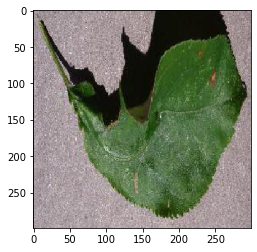

In [6]:
#loading and preprocessing cat image
IMAGE_PATH='../plant_classifier/dataset/train/Apple___Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727_270deg.JPG'
img=tf.keras.preprocessing.image.load_img(IMAGE_PATH,target_size=(299,299))
img=tf.keras.preprocessing.image.img_to_array(img)
#view the image
plt.imshow(img/255.)

In [7]:
import requests
#fetching labels from Imagenet  
response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
imgnet_map=response.json()
imgnet_map={v[1]:k for k, v in imgnet_map.items()}
#make model predictions
img=tf.keras.applications.xception.preprocess_input(img)
predictions=model.predict(np.array([img]))
decode_predictions(predictions,top=5)

40960/35363 [==================================] - 0s 1us/step


[[('n03991062', 'pot', 0.06775915),
  ('n01496331', 'electric_ray', 0.06562862),
  ('n07718472', 'cucumber', 0.06207276),
  ('n07720875', 'bell_pepper', 0.041077647),
  ('n12620546', 'hip', 0.029821105)]]

In [8]:
# See full code and description on GitHub
# https://github.com/voandy/monkey-classifier

import os.path

from keras import Model, optimizers
from keras.applications import xception
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator

img_width = 250
img_height = 250

epochs = 1
epochs_ft = 1
batch_size = 120

train_path = '../plant_classifier/dataset/train'
validation_path = '../plant_classifier/dataset/valid'

nb_classes = 37

# Counts the number of training and testing samples in the directories
training_samples = sum([len(files) for r, d, files in os.walk(train_path)])
testing_samples = sum([len(files) for r, d, files in os.walk(validation_path)])

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.2,
    rescale=1.0 / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)


# Adds new top to base model
def add_top(base):
    x = base.output

    # Global averaging pool layer
    x = GlobalAveragePooling2D()(x)

    # Regular densely connected layer
    x = Dense(512, activation='relu')(x)

    # Output layer
    predictions = Dense(nb_classes, activation='softmax')(x)

    return Model(input=base.input, output=predictions)


# Sets up model for transfer learning
def setup_model(model, base):
    # Freeze the un-trainable layers of the model base
    for layer in base.layers:
        layer.trainable = False

    model.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )


# Import the Xception model to use as the base for our model
xception_base = xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, 3)
)

model = add_top(xception_base)
setup_model(model, xception_base)

# Train our new top layer
model.fit_generator(
    train_generator,
    steps_per_epoch=training_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=testing_samples // batch_size,
    verbose=1,
)


# Setup model for fine tuning
def setup_model(model, trainable):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss='categorical_crossentropy',
        # Slower training rate for fine-tuning
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy']
    )


# Setup model to retrain our top layer plus block 13 and 14 of Xception
setup_model(model, 19)

# Fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=training_samples // batch_size,
    epochs=epochs_ft,
    validation_data=test_generator,
    validation_steps=testing_samples // batch_size,
    verbose=1,
)

Found 69079 images belonging to 37 classes.
Found 17068 images belonging to 37 classes.
83689472/83683744 [==============================] - 17s 0us/step


TypeError: ('Keyword argument not understood:', 'input')

In [ ]:
"""
Author: Abner Ayala-Acevedo

This script based on examples provided in the keras documentation and a blog.
"Building powerful image classification models using very little data"
from blog.keras.io.

Dataset: Subset of Kaggle Dataset
https://www.kaggle.com/c/dogs-vs-cats/data
- cat pictures index 0-999 in data/train/cats
- cat pictures index 1000-1400 in data/validation/cats
- dogs pictures index 0-999 in data/train/dogs
- dog pictures index 1000-1400 in data/validation/dogs

Example: Dogs vs Cats (Directory Structure)
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...

Example has 1000 training examples for each class, and 400 validation examples for each class.
The data folder already contains the dogs vs cat data you simply need to run script. For the dogs_cats classification
you can find a model already trained in the model folder. Feel free to create your own data.
"""

import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k

# fix seed for reproducible results (only works on CPU, not GPU)
seed = 9
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

# hyper parameters for model
nb_classes = 2  # number of classes
based_model_last_block_layer_number = 126  # value is based on based model selected.
img_width, img_height = 299, 299  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation


def train(train_data_dir, validation_data_dir, model_path):
    # Pre-Trained CNN Model using imagenet dataset for pre-trained weights
    base_model = Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)

    # Top Model Block
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    # add your top layer block to your base model
    model = Model(base_model.input, predictions)
    print(model.summary())

    # # let's visualize layer names and layer indices to see how many layers/blocks to re-train
    # # uncomment when choosing based_model_last_block_layer
    # for i, layer in enumerate(model.layers):
    #     print(i, layer.name)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all layers of the based model that is already pre-trained.
    for layer in base_model.layers:
        layer.trainable = False

    # Read Data and Augment it: Make sure to select augmentations that are appropriate to your images.
    # To save augmentations un-comment save lines and add to your flow parameters.
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=transformation_ratio,
                                       shear_range=transformation_ratio,
                                       zoom_range=transformation_ratio,
                                       cval=transformation_ratio,
                                       horizontal_flip=True,
                                       vertical_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    os.makedirs(os.path.join(os.path.abspath(train_data_dir), '../preview'), exist_ok=True)
    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
    # save_to_dir=os.path.join(os.path.abspath(train_data_dir), '../preview')
    # save_prefix='aug',
    # save_format='jpeg')
    # use the above 3 commented lines if you want to save and look at how the data augmentations look like

    validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                                  target_size=(img_width, img_height),
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical')

    model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])

    # save weights of best training epoch: monitor either val_loss or val_acc

    top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
    callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_acc', patience=5, verbose=0)
    ]

    # Train Simple CNN
    model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.nb_sample,
                        nb_epoch=nb_epoch / 5,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.nb_sample,
                        callbacks=callbacks_list)

    # verbose
    print("\nStarting to Fine Tune Model\n")

    # add the best weights from the train top model
    # at this point we have the pre-train weights of the base model and the trained weight of the new/added top model
    # we re-load model weights to ensure the best epoch is selected and not the last one.
    model.load_weights(top_weights_path)

    # based_model_last_block_layer_number points to the layer in your model you want to train.
    # For example if you want to train the last block of a 19 layer VGG16 model this should be 15
    # If you want to train the last Two blocks of an Inception model it should be 172
    # layers before this number will used the pre-trained weights, layers above and including this number
    # will be re-trained based on the new data.
    for layer in model.layers[:based_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[based_model_last_block_layer_number:]:
        layer.trainable = True

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # save weights of best training epoch: monitor either val_loss or val_acc
    final_weights_path = os.path.join(os.path.abspath(model_path), 'model_weights.h5')
    callbacks_list = [
        ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    ]

    # fine-tune the model
    model.fit_generator(train_generator,
                        samples_per_epoch=train_generator.nb_sample,
                        nb_epoch=nb_epoch,
                        validation_data=validation_generator,
                        nb_val_samples=validation_generator.nb_sample,
                        callbacks=callbacks_list)

    # save model
    model_json = model.to_json()
    with open(os.path.join(os.path.abspath(model_path), 'model.json'), 'w') as json_file:
        json_file.write(model_json)


if __name__ == '__main__':
    if not len(sys.argv) == 3:
        print('Arguments must match:\npython code/train.py <data_dir/> <model_dir/>')
        print('Example: python code/train.py data/dogs_cats/ model/dog_cats/')
        sys.exit(2)
    else:
        data_dir = os.path.abspath(sys.argv[1])
        train_dir = os.path.join(os.path.abspath(data_dir), 'train')  # Inside, each class should have it's own folder
        validation_dir = os.path.join(os.path.abspath(data_dir), 'validation')  # each class should have it's own folder
        model_dir = os.path.abspath(sys.argv[2])

        os.makedirs(os.path.join(os.path.abspath(data_dir), 'preview'), exist_ok=True)
        os.makedirs(model_dir, exist_ok=True)

    train(train_dir, validation_dir, model_dir)  # train model

    # release memory
    k.clear_session()